<a href="https://colab.research.google.com/github/JaquelineJunko/CyberLabs-Classificador_de_Digitos-/blob/main/Digits_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sobre o problema e o classificador

Para a classificação das imagens 0 e 5 do dataset MNIST, inicialmente é proposto uma rede neural Multilayer Perceptron (MLP).

O MLP possui uma camada de entrada com 784 (28*28) entradas, uma camada oculta com 56 neurônios e uma camada de saída Softmax de duas classes. 

Mas o porque do MLP? Redes neurais são algoritmos mais robustos, mais especificamente, redes neurais convolucionais (CNNs) são projetadas para a análise de imagens. A camada de classificação de uma CNN rede é basicamente um MLP. Dessa forma, surgiu a ideia de se utilizar essa arquitetura. No entanto, como o MLP utiliza dados na forma de vetores unidimensionais, as imagens foram redimensionadas para tal forma.

# Importar Bibliotecas

In [ ]:
from torchvision import datasets
from torchvision import transforms

from torch.utils.data import DataLoader 

import torch 
from torch import nn, optim

import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [ ]:
args = {
    'batch_size': 100,
    'num_workers': 4,
    'num_classes': 10,
    'lr': 1e-4,
    'weight_decay': 5e-4,
    'num_epochs': 20
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Criando conjunto de treino e teste


Com o parâmetro train = True, já é possível obter o conjunto de treino, segundo o dataset MNIST. Depois de carregado o dataset completo, realiza-se uma filtragem das amostras que possuem os rótulos 0 ou 5. O mesmo processo é realizado para o conjunto de teste, em que train = False.


In [ ]:
# Train
train_set = datasets.MNIST('data', 
                           train=True, 
                           download=True,
                           transform=transforms.ToTensor())
# Filtrando imagens dos dígitos 0 e 5
idx_train = (train_set.targets==0) | (train_set.targets==5) # idx_train é um tensor de True e False
train_set.targets = train_set.targets[idx_train]
train_set.data = train_set.data[idx_train]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Test
test_set = datasets.MNIST('data', 
                          train=False, 
                          download=True,
                          transform=transforms.ToTensor())
idx_test = (test_set.targets==0) | (test_set.targets==5)
test_set.targets = test_set.targets[idx_test]
test_set.data = test_set.data[idx_test]

## Mapeando as Classes do Dígito 5

Para classificarmos as imagens nas classes 0 ou 5, adotamos que a classe 5 terá como rótulo 1. Assim, o padrão adotado:   
> Imagens com digito 0 : **Classe 0**


> Imagens com dígito 5:  **Classe 1**

Nos seguintes passos, é realizado a troca dos targets 5 para 1, tanto no conjunto de teste, quanto no conjunto de





In [ ]:
# Troca do target no conjunto de treino
print('Classe Antes')
print(train_set.targets)
for idx in range(len(train_set)):
  _ , target = train_set[idx]
  if (target == 5):
    train_set.targets[idx] = 1

print('\nClasse Depois')
print(train_set.targets)

Classe Antes
tensor([5, 0, 5,  ..., 0, 5, 5])

Classe Depois
tensor([1, 0, 1,  ..., 0, 1, 1])


In [ ]:
# Troca do target no conjunto de teste
print('Classe Antes')
print(test_set.targets)
for idx in range(len(test_set)):
  _ , target = test_set[idx]
  if (target == 5):
    test_set.targets[idx] = 1

print('\n Classe Depois')
print(train_set.targets)

Classe Antes
tensor([0, 5, 0,  ..., 5, 0, 5])

 Classe Depois
tensor([1, 0, 1,  ..., 0, 1, 1])


# Informações do Dataset

In [ ]:
train_set

Dataset MNIST
    Number of datapoints: 11344
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_set

Dataset MNIST
    Number of datapoints: 1872
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
print(type(train_set))
print(type(train_set[0]))
data, target = train_set[0]
print(data.shape) # dimensões(1 canal de cor, 28 pixels por 28 pixels)
print(type(target))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>
torch.Size([1, 28, 28])
<class 'int'>


In [ ]:
type(data), type(target)

(torch.Tensor, int)

Das informações obtidas:

- O conjunto de treino possui **11344** amostras
- O conjunto de teste possui **1872** amostras
- O conjunto de treino/teste é composto por **tuplas**  <pixels da imagem, rótulo de classe> do tipo <tensor, int>
- Cada imagem tem um canal de cor e dimensões 28x28 (torch.Size([1, 28, 28]))

In [ ]:
data[0][1] # imprimir valores do pixels da 2 linha

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

# Visualizando algumas imagens do conjunto de treino e teste

Dados do cojunto de TREINO
Amostras de treino: 11344 | Amostras de Dígito 0: 5923 | Amostras de Dígito 5: 5421


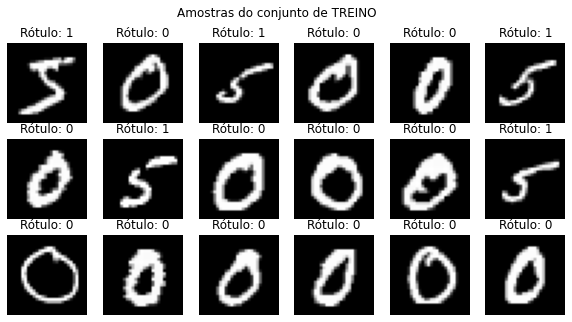

In [ ]:
num_samples = str(len(train_set.data))
zero = sum(train_set.targets == 0)
cinco = sum(train_set.targets == 1)
print('Dados do cojunto de TREINO')
print(f'Amostras de treino: {num_samples} | Amostras de Dígito 0: {zero} | Amostras de Dígito 5: {cinco}')

plt.figure(figsize=(10, 5))
for i in range(18): 
  data, target = train_set[i]
  plt.subplot(3, 6, i+1)
  plt.axis('off')
  plt.suptitle('Amostras do conjunto de TREINO')
  plt.imshow(data[0],cmap='gray')
  plt.title('Rótulo: '+ str(target))


Dados do cojunto de TESTE
Amostras de teste: 1872 | Amostras de Dígito 0: 980 | Amostras de Dígito 5: 892


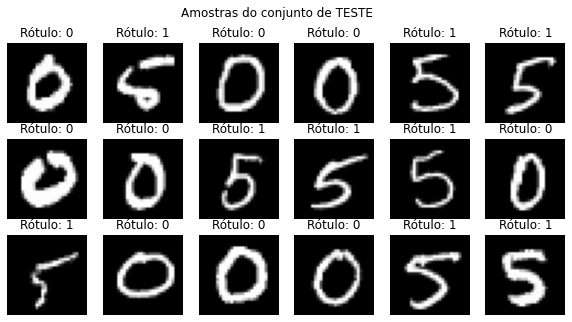

In [ ]:
num_samples = str(len(test_set.data))
zero = sum(test_set.targets == 0)
cinco = sum(test_set.targets == 1)
print('\nDados do cojunto de TESTE')
print(f'Amostras de teste: {num_samples} | Amostras de Dígito 0: {zero} | Amostras de Dígito 5: {cinco}')

plt.figure(figsize=(10, 5))
for i in range(18):
  data, target = test_set[i]
  plt.subplot(3, 6, i+1)
  plt.axis('off')
  plt.suptitle('Amostras do conjunto de TESTE')
  plt.imshow(data[0], cmap='gray')
  plt.title('Rótulo: '+ str(target))

# Dataloader de Treino e Teste

Como será utilizado um Multilayer Perceptron, o DataLoader consegue gerenciar o treinamento da rede com a separação dos dados em batches, função de shuffle e carregar esses batches em paralelo. Ou seja, para cada época, a rede será treinada com um subconjunto das imagens.

---

"While training a model, we typically want to pass samples in "minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API. DataLoader wraps an iterable around the Dataset to enable easy access to the samples." 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Multilayer Perceptron
 

In [ ]:
class MLP(nn.Module):
  def __init__(self,input_size, hidden_size, out_size):
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
                      nn.Linear(input_size, hidden_size), # Camada de entrada
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size), # Camada intermediaria 
                      nn.ReLU()
    )
      
    # self.out =      nn.Sequential(      
    #                     nn.Linear(hidden_size, out_size),
    #                     nn.Softmax()
    # )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()
    

  def forward(self, input_data):
      input_data = input_data.view(input_data.size(0), -1) # Redimensionar os dados na forma de uma vetor linear

      # feature = self.features(input_data) # Passando os dados pelas camadas do MLP
      # output = self.out(feature)
      feature = self.features(input_data)
      output  = self.softmax(self.out(feature))
      
      return output

In [ ]:
# Função que retorna a classe original das imagens do conjunto
def get_data_target(data_set):
  # Saida esperada
  data_target = [] 
  for tup in data_set:
    _, target = tup
    data_target.append(target)
  return data_target

In [ ]:
# Função que retorna as predições do MLP
def get_prediction_target(data_set):

  # Saida prevista
  images = torch.stack([tup[0] for tup in data_set]) # pegar imagens do conjunto de teste
  images = images.to(args['device'])
  prediction = classifier(images) # resultado da classificação da rede

  # Transformando a saida da softmax em uma predicao
  prediction_target = []
  for tup in prediction:
    _, idx = torch.max(tup, axis=-1) # posicao do maior valor resultante da previsao softmax
    prediction_target.append(torch.IntTensor.item(idx))
  return prediction_target

## Instanciando o Classificador


In [ ]:
input_size  = 28 * 28
hidden_size = 56
out_size    = 2

classifier = MLP(input_size, hidden_size, out_size).to(args['device'])

In [ ]:
# Ver especificações da Rede
print(classifier)

MLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=56, bias=True)
    (1): ReLU()
    (2): Linear(in_features=56, out_features=56, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=56, out_features=2, bias=True)
  (softmax): Softmax(dim=None)
)


# Função de Perda e Otimizador

Função de Perda: mede o quão longe o valor predito está do seu valor verdadeiro. **CrossEntropyLoss**: É útil ao treinar um problema de classificação com C classes. 

Optimizer: Um otimizador é utilizado para determinar de que maneira os pesos serão atualizados, de forma a reduzir os erros.

In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(classifier.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Fluxo de Treinamento da Arquitetura

Basicamente o fluxo segue os seguintes passos, no qual as épocas serão iteradas quando chamado o treinamento/teste

1.   Iterar nas épocas
2.   Iterar nos batches
3.   Forward na rede e cálculo da loss
4.  Cálculo do gradiente e atualização dos pesos

In [ ]:
def train(train_loader, classifier, epoch):

  # Training mode
  classifier.train()
  
  start = time.time()
  
  epoch_loss  = []

  for batch in train_loader:
    image, target = batch

    # Cast do dado na GPU
    image = image.to(args['device'])
    target = target.to(args['device'])

    # Forward 
    prediction = classifier(image)
    loss = criterion(prediction, target)
    epoch_loss.append(loss.cpu().data)

    # Backward
    loss.backward() # mutiple times accumulates the gradient (by addition) for each parameter.
    optimizer.step() # performs a parameter update based on the current gradient and the update rule
    optimizer.zero_grad()
    
  epoch_loss = np.asarray(epoch_loss) # armazenar a loss da epoca atual
  end = time.time()

  print('#################### Train ####################')
  print("Epoca %d, Loss: %.4f +/- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start) )
  return epoch_loss.mean()

In [ ]:
def validate(test_loader, classifier, epoch):

  # Evaluation mode
  classifier.eval()
  
  start = time.time()
  
  epoch_loss  = []

  with torch.no_grad(): 
    for batch in test_loader:
      image, target = batch

      # Cast do dado na GPU
      image = image.to(args['device'])
      target = target.to(args['device'])
      
      # Forward 
      prediction = classifier(image)
      loss = criterion(prediction, target)
      epoch_loss.append(loss.cpu().data)
      
  epoch_loss = np.asarray(epoch_loss) # armazenar a loss da epoca atual

  end = time.time()
  print('******************* Validate ******************')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()

In [ ]:
train_losses, test_losses = [], []
train_acc, test_acc = [], []
# Obter as classes das imagens nos conjutos de treino e teste
train_targets = get_data_target(train_set) 
test_targets = get_data_target(test_set)

for epoch in range(args['num_epochs']):
  
  # Train
  train_losses.append(train(train_loader, classifier, epoch))
  ## Calcular a acurácia em cada época
  train_predict_target = get_prediction_target(train_set)
  train_acc.append(accuracy_score(train_targets, train_predict_target))

  # Validate
  test_losses.append(validate(test_loader, classifier, epoch))
  ## Calcular a acurácia em cada época
  test_predict_target = get_prediction_target(test_set)
  test_acc.append(accuracy_score(test_targets, test_predict_target))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#################### Train ####################
Epoca 0, Loss: 0.6024 +\- 0.0655, Tempo: 1.67
******************* Validate ******************
Epoch 0, Loss: 0.4739 +/- 0.0075, Time: 0.39

#################### Train ####################
Epoca 1, Loss: 0.4092 +\- 0.0346, Tempo: 1.67
******************* Validate ******************
Epoch 1, Loss: 0.3594 +/- 0.0072, Time: 0.38

#################### Train ####################
Epoca 2, Loss: 0.3532 +\- 0.0130, Tempo: 1.71
******************* Validate ******************
Epoch 2, Loss: 0.3386 +/- 0.0089, Time: 0.41

#################### Train ####################
Epoca 3, Loss: 0.3405 +\- 0.0100, Tempo: 1.67
******************* Validate ******************
Epoch 3, Loss: 0.3321 +/- 0.0080, Time: 0.38

#################### Train ####################
Epoca 4, Loss: 0.3355 +\- 0.0107, Tempo: 1.67
******************* Validate ******************
Epoch 4, Loss: 0.3285 +/- 0.0084, Time: 0.39

#################### Train ####################
Epoca 5, Los

# Exibição da Perda e Acurácia em cada Época

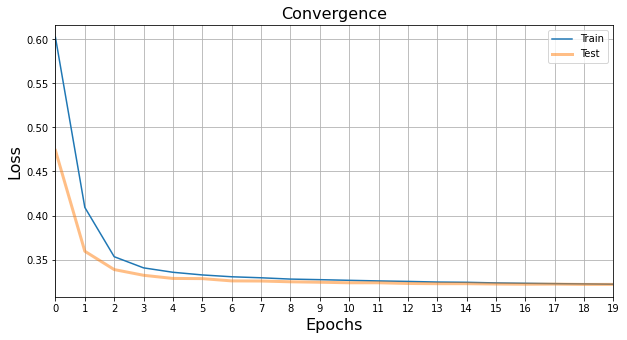

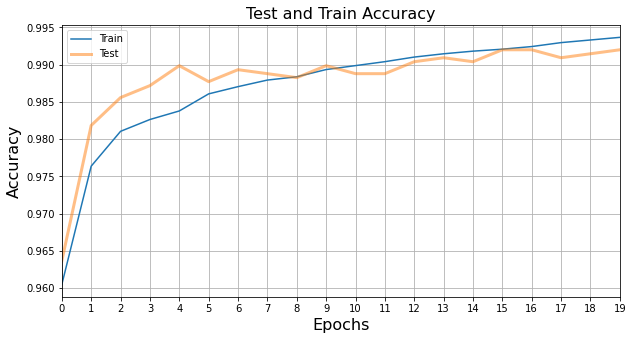

In [ ]:
x_axis = np.arange(0, int(args['num_epochs']), 1);
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(x_axis)
plt.xlim(0,int(args['num_epochs']-1))
plt.grid()
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()

x_axis = np.arange(0, int(args['num_epochs']), 1);
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(x_axis)
plt.xlim(0,int(args['num_epochs'])-1)
plt.grid()
plt.title('Test and Train Accuracy', fontsize=16)
plt.legend()
plt.show()

## Análise dos Gráficos

In [ ]:
losses = []
for i in range(len(train_losses)):
  if (train_losses[i] > test_losses[i]):
    losses.append((i,True))
  else:
    losses.append((i,False))
print(losses)

[(0, True), (1, True), (2, True), (3, True), (4, True), (5, True), (6, True), (7, True), (8, True), (9, True), (10, True), (11, True), (12, True), (13, True), (14, True), (15, True), (16, True), (17, True), (18, True), (19, True)]


In [ ]:
overfit = []
for i in range(len(train_acc)):
  if (train_acc[i] > test_acc[i]):
    overfit.append((i,True))
  else:
    overfit.append((i,False))
print(overfit)

[(0, False), (1, False), (2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, True), (9, False), (10, True), (11, True), (12, True), (13, True), (14, True), (15, True), (16, True), (17, True), (18, True), (19, True)]


Comparando as perdas obtidas dos conjuntos de treino e teste, tem-se que sempre a **perda do conjunto de treino é sempre maior do que a perda do conjunto de teste**, o que é um indício de que a rede não está sofrendo a tendencia de overfitting nos dados de treino.

Apesar disso, a acurácia obtida nos modelos de treino tendem a ultrapassar a acurácia do conjunto de treino. Enquanto o desempenho nesses tendem a oscilar, no treino há um aumento cada vez maior da acurácia, indicando que o modelo está se especializando nesse conjunto.

Por fim, já na primeira iteração há um valor considerável de acurácia (acima de 95%), chegando a valores maiores que 99%.

# Matriz de Confusão

A matriz de confusão mensura a quantidade de amostras que foram corretamente e incorretamente rotuladas.

Por definição, cada elemento C(i,j) é igual ao número de observações que se sabe estarem no grupo i e que se prevê que estejam no grupo j.

Dessa forma:

*   972 imagens de número 0 foram classificadas como 0
*   8   imagens de número 0 foram classificadas como 5
*   885 imagens de número 5 foram classificadas como 5
*   7   imagens de número 5 foram classificadas como 0



In [ ]:
confusion_matrix(test_targets, test_predict_target)

array([[972,   8],
       [  7, 885]])

# Comparação com outro classificador

In [ ]:
# train_svm = []
# train_target_svm = []
# for tup in train_set:
#   image, target = tup
#   data = image.view(28*28).numpy()
#   train_svm.append(data)
#   train_target_svm.append(target)
# print(train_target_svm)

# test_svm = []
# test_target_svm = []
# for tup in test_set:
#   image, target = tup
#   data = image.view(28*28).numpy()
#   test_svm.append(data)
#   test_target_svm.append(target)


[5, 0, 5, 0, 0, 5, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5, 5, 0, 0, 5, 0, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 0, 0, 5, 5, 5, 0, 5, 5, 0, 5, 5, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 5, 0, 5, 5, 5, 0, 5, 0, 0, 0, 5, 0, 5, 5, 5, 5, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 5, 5, 0, 0, 0, 5, 5, 0, 0, 0, 5, 5, 5, 5, 5, 5, 0, 5, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 5, 5, 0, 5, 0, 5, 5, 5, 5, 5, 0, 0, 5, 0, 0, 5, 0, 5, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 5, 0, 0, 0, 5, 5, 0, 0, 5, 5, 0, 0, 0, 5, 0, 5, 5, 0, 5, 0, 0, 5, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 0, 5, 5, 0, 0, 5, 5, 5, 0, 5, 0, 0, 0, 5, 0, 5, 5, 0, 5, 5, 0, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 0, 0, 0, 5, 0, 0, 5, 5, 0, 5, 0, 5, 0, 0, 5, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 5, 5, 0, 0, 0, 5, 5, 

In [ ]:
type(train_svm[0])

numpy.ndarray

In [ ]:
# train_svm = np.array(train_svm)
# test_svm = np.array(test_svm)
# train_target_svm = np.array(train_target_svm)
# test_target_svm = np.array(test_target_svm)

In [ ]:
# svm_classifier = svm.SVC(kernel='rbf') 
# svm_classifier.fit(train_svm, train_target_svm)
# # y_pred = svm_classifier.predict(test_svm)
# # confusion_matrix(y_test, y_pred)

ValueError: ignored